# CEM Workflow Notebook
### Coastal Group, ESPIn 2021 Group Project
Created by Benton Franklin, Conner Lester, & Megan Gillen; 6-14-21
<br>Last Updated: 6-16-21

### Relevant References:
Ashton A., Murray B.A., Arnault O. [Formation of Coastline Features by Large-Scale Instabilities Induced by High-Angle Waves.](https://www.nature.com/articles/35104541) Nature Magazine. Volume 414. 15 November 2001. <br>
Ashton A.D., Murray A.B. [High-Angle Wave Instability and Emergent Shoreline Shapes: 1. Wave Climate Analysis and Comparisons to Nature.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005JF000422) Journal of Geophysical Research. Volume 111. 15 December 2006. <br>
Ashton A.D., Murray A.B. [High-Angle Wave Instability and Emergent Shoreline Shapes: 2. Wave Climate Analysis and Comparisons to Nature.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005JF000423) Journal of Geophysical Research. Volume 111. 15 December 2006.

### 1. Import Relevant Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymt.models import Cem, Waves
from IPython.display import clear_output

### 2. Initialize Models from PyMT
We are using the [Coastal Evolution Model (CEM)](https://csdms.colorado.edu/wiki/Model_help:CEM) and the [WAVES](https://csdms.colorado.edu/wiki/Model_help:Waves) models. The CEM simulates morphodynamic evolution of coastlines under varying wave climates. WAVES is the model that calculates the input wave energetics used in CEM as a function of wave period (T), deep water wave height (H<sub>0</sub>), and wave angle criteria. Run the help() commands on each function and read through their documentation.

In [2]:
cem = Cem()
waves = Waves()

In [ ]:
help(cem)

In [ ]:
help(waves)

Let's look at what variables go into and come out of each model. We'll first look at the input variables, then the output variables.

In [ ]:
waves.input_var_names

### WAVES Model Input Parameters
- `sea_surface_water_wave__height` --> Deep water wave height (H<sub>0</sub>)
- `sea_surface_water_wave__period` --> Wave period (T)
- `sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter` --> Proportion of high angle waves (U)
> "The variable U controls the general directional spread of the approaching waves, here split into whether waves approach from angles great than or less than the one which maximized alongshore sediment transport (approximately 45 degrees)...U varies between 0-1, controls the fraction of high-angle waves, where a value of less than 0.5 indicates wave energy predominately approaching from a low angle and a designation greater than 0.5 indicates a predominance of high-angle (unstable waves)."
> "This variable is probably the most important control on the behavior of coupled CEM-WAVES simulations using this simplified wave climate scheme. If CEM is being employed to simulate the self-organization of a coast, values of U larger than 0.5 should be used. For scenarios involving delta evolution, values less than 0.5 tend to be more reasonable (unless a local wave climate has that character). There is no specific method for deriving these terms (U and A) from natural wave climate conditions. Either A and U can be toggled to emulate a natural wave or other methods can be employed (not yet functional) where a natural wave climate can be enetered into the model." 
- `sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter` --> Asymmetry of wave direction (A)
> "The variable A controls the directional distribution of waves, representing the fraction of waves approaching from the left or right, from the perspective of a person looking out to sea. It is designated to be a value between 0 and 1. A designation of greater than 0.5 indicates that the majority of wave energy is approaching from the left where a designation of 1.0 indicates all wave energy approaches from the left. A designation of 0.5 indicates wave energy approach is evenly distributed between the left and right. A designation of less than 0.5 indicates the majority of wave energy is approaching from the right where a designation of 0 indicates all wave energy approaches from the right."

[WAVES Documentation](https://csdms.colorado.edu/wiki/Model_help:Waves)

In [ ]:
waves.output_var_names

### WAVES Model Output Parameters
- `sea_surface_water_wave__min_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity` --> 
- `sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity` --> Wave refraction angle ($\alpha$)
- `sea_surface_water_wave__mean_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity` --> 
- `sea_surface_water_wave__max_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity` --> 
- `sea_surface_water_wave__height` --> Wave period (T)
- `sea_surface_water_wave__period` --> Deep water wave height (H<sub>0</sub>)

In [ ]:
cem.input_var_names

In [ ]:
cem.output_var_names

Below we reassign the long variable names to simple characters. Saves us typing in the future! See above for documentation on what each variable represents.

In [3]:
H0 = 'sea_surface_water_wave__height'
T = 'sea_surface_water_wave__period'
U = 'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter'
A = 'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter'
alpha = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'
Qs = 'land_surface_water_sediment~bedload__mass_flow_rate'
Z = 'sea_water__depth'
dt = 'model__time_step'

The **plot_coast** function helps make our plots look nicer based on our created grid criteria. We will be using this throughout the notebook to visualize our changing coastlines.

In [4]:
def plot_coast(z):
    fig,ax = plt.subplots(figsize=(12,5))
    im = ax.imshow(z, origin='lower', cmap='viridis_r')
    cb = fig.colorbar(im,ax=ax)
    cb.ax.set_ylabel('Water Depth (m)',fontsize=20,rotation=-90, labelpad=30)
    cb.ax.tick_params('y',labelsize=15)
    ax.set_xlabel('Along shore (km)',fontsize=20)
    ax.set_ylabel('Cross shore (km)',fontsize=20)
    ax.tick_params('both',labelsize=15)

In [5]:
def update_animate(time,z,update_period=100):
        if time%update_period == 0:
            clear_output(wait=True)
            cem.get_value(Z, out=z)
            plot_coast(z)
            plt.title('Time Step: '+ str(time),fontsize=20)
            plt.show()

In [6]:
def run_model_loop(Number_Iterations, z ,animate=True):
    
    for time in range(Number_Iterations):
        waves.update()
        angle = waves.get_value(alpha)
        cem.set_value(alpha, angle)
        #H = waves.get_value(H0)
        #cem.set_value(H0,H)
        #period = waves.get_value(T)
        #cem.set_value(T,period)
        cem.set_value(Qs, qs)
        cem.update()
        if animate:
            update_animate(time,z)

        else:
            clear_output(wait=True)
            print('Time Step: ',time, ' days')

In [7]:
args = cem.setup(number_of_rows=100, number_of_cols=200, grid_spacing=200.)

waves.initialize(*waves.setup())
cem.initialize(*args)

In [8]:
grid_id = cem.var_grid(Z)
spacing = cem.grid_spacing(grid_id)
shape = cem.grid_shape(grid_id)

In [9]:
waves.set_value(H0, 1.5);
waves.set_value(T, 7);
waves.set_value(U, .8);
waves.set_value(A, .3);

In [10]:
z = np.empty(shape);
cem.get_value(Z, out=z);
qs = np.zeros_like(z);
qs[0, 50] = 50;
qs[0, 100] = 200;
qs[0, 150] = 1000;

model_run = 365*20

In [11]:
run_model_loop(10000,z,animate=False)

Time Step:  9999


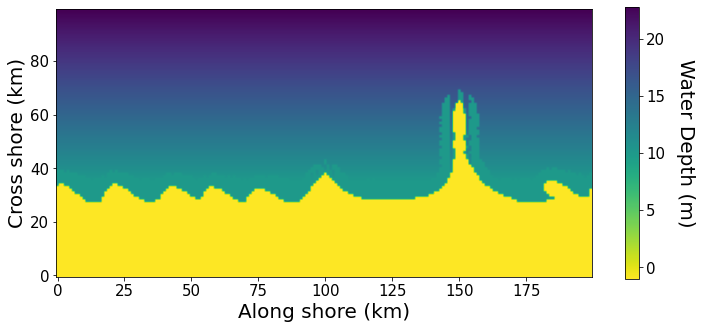

In [12]:
z_end = np.empty(shape)
cem.get_value(Z, out=z_end)
plot_coast(z_end)